In [1]:
from pathinit import *

import numpy as np
import scipy as sc

import jax
import jax.numpy as jnp
import jax.scipy as jsc

from jax import grad, jit, vmap
from jax import jacfwd, jacrev, hessian

import jaxopt
import optax

jax.config.update("jax_enable_x64", True)

import matplotlib as mpl
from matplotlib import pyplot as plt

import corner
import arviz as az
mpl.rcParams['font.size'] = 20

# Thème: pratiquer de nouveau de l'optimisation avec la librairie `jaxopt` ([doc](https://jaxopt.github.io/stable/index.html))

Soit le modèle 1D paramétré suivant:
$$
\Large
f(t) = R_0 + v t - \Theta(t)\times k(1-e^{t/\tau})\qquad avec \quad \Theta(t) = 1 (t>=0), 0 (t<0)
\\
$$
On va générer des données bruitées (`forward modeling`) puis on va effectuer de l'`inférence` (estimation).

In [2]:
def mean_fn(x, params):
    """Parametrisation avant et apres (t=0) """
    R0 = params["R0"]
    v  = params["v"]
    k  = params["k"]
    tau =  params["tau"]
    return jnp.where(x < 0, R0 + v*x, R0 + v*x - k*(1.-jnp.exp(-x/tau)))

In [3]:
par_true={"R0":35.0, "v":2.20, "k":15.5, "tau": 1.0}
sigma_obs=1.0

In [4]:
rng_key = jax.random.PRNGKey(42)
rng_key, rng_key0, rng_key1, rng_key2 = jax.random.split(rng_key, 4)

In [5]:
#?jax.random.PRNGKey

Il est d'usage de prendre une clé et de la dupliquer, les clés peuvent être distribuées...

In [6]:
rng_key, rng_key0, rng_key1, rng_key2

(Array([2954079971, 2575172198], dtype=uint32),
 Array([1139032965, 1035738655], dtype=uint32),
 Array([3276725750, 1223413151], dtype=uint32),
 Array([173471767,  13772463], dtype=uint32))

In [7]:
tMes = jax.random.uniform(rng_key0,minval=-5.,maxval=5.0,shape=(20,))
tMes=jnp.append(tMes,0.0)
tMes=jnp.sort(tMes)

In [8]:
RMes = mean_fn(tMes,par_true) + sigma_obs * jax.random.normal(rng_key1,shape=tMes.shape)

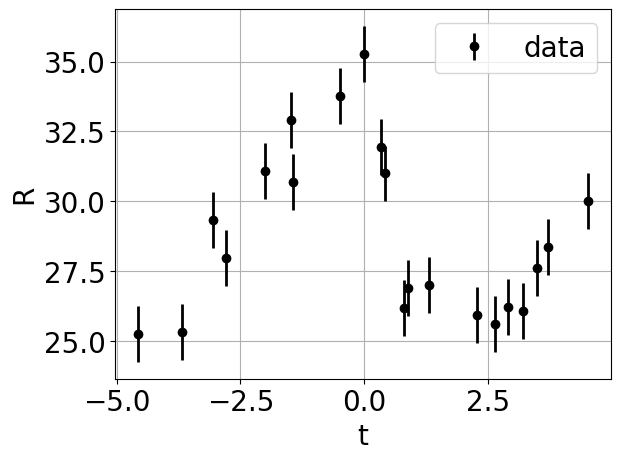

In [9]:
plt.errorbar(tMes,RMes,yerr=sigma_obs,fmt='o', linewidth=2, capsize=0, c='k', label="data")
plt.xlabel("t")
plt.ylabel("R")
plt.legend()
plt.grid();

On se fixe un likelihood gaussien (log-likelihood quadratique) résidus normalisés par l'erreur de mesure

In [10]:
def lik(p,t,R, sigma_obs=1.0):
    params = {"R0":p[0], "v":p[1], "k":p[2], "tau": p[3]}
    resid = mean_fn(t, params)-R
    return 0.5*jnp.sum((resid/sigma_obs) ** 2) 

In [11]:
def get_infos(res, model, t,R):
    params    = res.params
    fun_min   = model(params,t,R)
    jacob_min =jax.jacfwd(model)(params, t,R)
    inv_hessian_min =jax.scipy.linalg.inv(jax.hessian(model)(params, t,R))
    return params,fun_min,jacob_min,inv_hessian_min

### Au lieu de faire une descente de gradient à la main on utilise la librairie jaxopt: `GradientDescent`, `optax solver`, `ScipyWrapper`.

In [12]:
gd = jaxopt.GradientDescent(fun=lik, maxiter=1000)
init_params = jnp.array([18.,1.,10.,1.])
res = gd.run(init_params,t=tMes, R=RMes)

In [13]:
params,fun_min,jacob_min,inv_hessian_min = get_infos(res, lik, t=tMes,R=RMes)
print("params:",params,"\nfun@min:",fun_min,"\njacob@min:",jacob_min,
     "\n invH@min:",inv_hessian_min)

params: [35.36653916  2.37454654 16.60209238  0.93105711] 
fun@min: 6.710336848470292 
jacob@min: [0.00425324 0.00190545 0.01147151 0.00063112] 
 invH@min: [[ 0.30761279  0.09638547  0.63828082 -0.00408842]
 [ 0.09638547  0.04649469  0.26423637  0.00267717]
 [ 0.63828082  0.26423637  1.84159393  0.04459909]
 [-0.00408842  0.00267717  0.04459909  0.01114583]]


In [14]:
opt = optax.adam(0.1)
solver = jaxopt.OptaxSolver(opt=opt, fun=lik, maxiter=10000)
init_params = jnp.array([18.,1.,10.,1.])
res = solver.run(init_params,t=tMes, R=RMes)

In [15]:
params,fun_min,jacob_min,inv_hessian_min = get_infos(res, lik, t=tMes,R=RMes)
print("params:",params,"\nfun@min:",fun_min,"\njacob@min:",jacob_min,
     "\n invH@min:",inv_hessian_min)

params: [35.35713338  2.37079478 16.57621824  0.93053084] 
fun@min: 6.710175452733031 
jacob@min: [-8.36101782e-04 -6.19403716e-05 -5.18760572e-04 -1.48194416e-05] 
 invH@min: [[ 0.30761646  0.09638606  0.63829251 -0.00407304]
 [ 0.09638606  0.04649234  0.26419596  0.00268056]
 [ 0.63829251  0.26419596  1.84090073  0.04456931]
 [-0.00407304  0.00268056  0.04456931  0.01114789]]


In [16]:
minimizer = jaxopt.ScipyMinimize(fun=lik,method='BFGS',options={'gtol': 1e-6,'disp': False})
init_params = jnp.array([18.,1.,10.,1.])
res1 = minimizer.run(init_params, t=tMes, R=RMes)
params,fun_min,jacob_min,inv_hessian_min = get_infos(res1, lik, t=tMes,R=RMes)
print("params:",params,"\nfun@min:",fun_min,"\njacob@min:",jacob_min,
     "\n invH@min:",inv_hessian_min)

params: [35.35772761  2.37101534 16.57772394  0.93055088] 
fun@min: 6.710174806788171 
jacob@min: [-4.49239472e-08 -2.15598979e-08  2.22663501e-08 -9.25418287e-08] 
 invH@min: [[ 0.30761634  0.09638602  0.63829182 -0.00407356]
 [ 0.09638602  0.04649244  0.26419768  0.00268039]
 [ 0.63829182  0.26419768  1.84093013  0.04456978]
 [-0.00407356  0.00268039  0.04456978  0.0111473 ]]


In [17]:
lbfgsb = jaxopt.ScipyBoundedMinimize(fun=lik, method="L-BFGS-B")
init_params = jnp.array([18.,1.,10.,1.])
res2 = lbfgsb.run(init_params, bounds=([10.,0.,0.,0.1],[100.,10.,50.,10.]), 
                 t=tMes, R=RMes)
params,fun_min,jacob_min,inv_hessian_min = get_infos(res2, lik, t=tMes, R=RMes)
print("params:",params,"\nfun@min:",fun_min,"\njacob@min:",jacob_min,
     "\n invH@min:",inv_hessian_min)

params: [35.35772729  2.37101488 16.57771912  0.93055001] 
fun@min: 6.710174806823519 
jacob@min: [-3.02633387e-06 -7.62787967e-06  1.56824322e-06 -8.41643259e-05] 
 invH@min: [[ 0.30761632  0.09638602  0.63829193 -0.00407349]
 [ 0.09638602  0.04649244  0.26419771  0.00268041]
 [ 0.63829193  0.26419771  1.84092994  0.04456978]
 [-0.00407349  0.00268041  0.04456978  0.01114726]]


### On va profiter de l'auto-diff pour ploter la loss-landscape

In [18]:
def plot_landscape(ax,model,xdata,ydata, par_min, idx=(0,1), bounds=(0.,1.,0.,1.), model_args=(), model_kwargs={}):
    xmin,xmax,ymin,ymax = bounds
    grid = x0,y0 = jnp.mgrid[xmin:xmax:101j,ymin:ymax:101j]

    pts = jnp.swapaxes(grid,0,-1).reshape(-1,2)
    points = jnp.repeat(par_min[None, :], pts.shape[0], axis=0)
    for i in (0,1):
        points = points.at[:,idx[i]].set(pts[:,i])
    
    vfunc = jit(vmap(lambda p,x,y: model(p,x,y,*model_args, **model_kwargs), in_axes = (0,None,None)))
    v = vfunc(points,xdata,ydata)
    v = jnp.swapaxes(v.reshape(101,101),0,-1)
    g0=ax.contourf(x0,y0,v, levels = 100)
    ax.contour(x0,y0,v, levels = 50, colors = 'w')

    grid = jnp.mgrid[xmin:xmax:10j,ymin:ymax:10j]
    pts = jnp.swapaxes(grid,0,-1).reshape(-1,2)
    points = jnp.repeat(par_min[None, :], pts.shape[0], axis=0)
    for i in (0,1):
        points = points.at[:,idx[i]].set(pts[:,i])

    gradients = jit(vmap(
        grad(
            lambda p,x,y: model(p,x,y, *model_args, **model_kwargs)
        ), in_axes = (0,None,None)
    ))(points,xdata,ydata)

    scale = int(0.2*np.max(gradients))
    ax.quiver(
        points[:,idx[0]],
        points[:,idx[1]],
        gradients[:,idx[0]],
        gradients[:,idx[1]],
        color="white",
        angles = 'xy',
        scale_units='xy',
        scale = scale
    )
    ax.set_aspect("equal")
    fig.colorbar(g0,ax=ax,shrink=0.5)

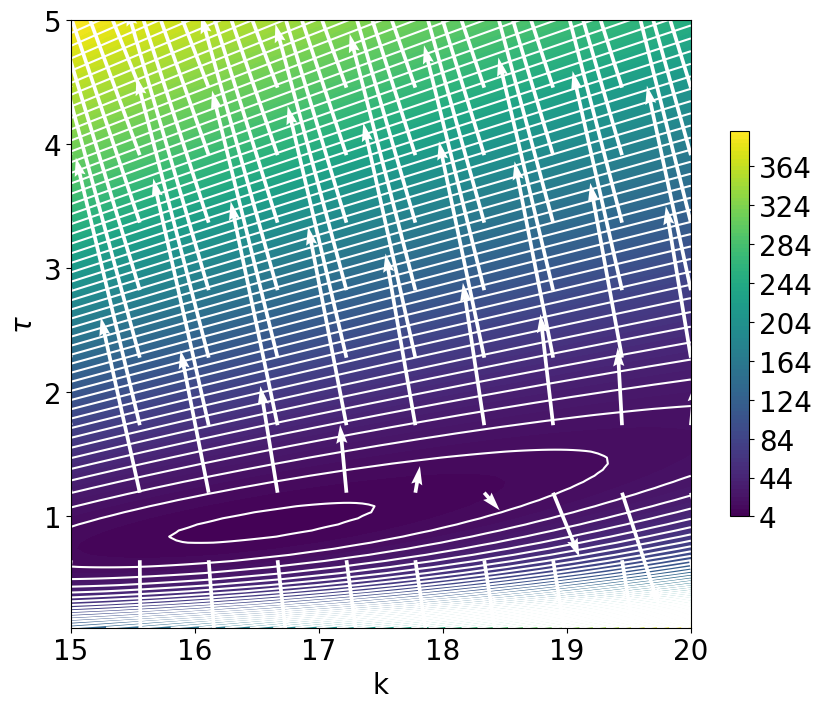

In [19]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
plot_landscape(ax,model=lik,xdata=tMes,ydata=RMes,par_min=params, idx=(2,3),bounds=(15,20.,0.1,5.))
plt.xlabel("k")
plt.ylabel(r"$\tau$")
plt.show()

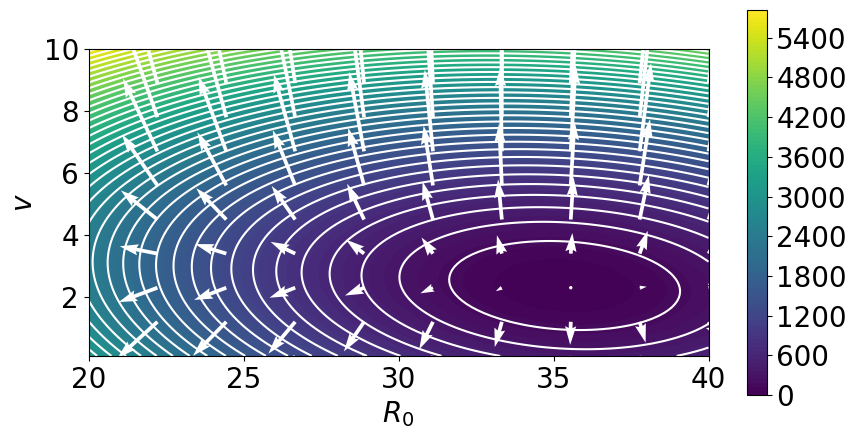

In [20]:
fig,ax = plt.subplots(1,1,figsize=(10,10))
plot_landscape(ax,model=lik,xdata=tMes,ydata=RMes,par_min=params, idx=(0,1),bounds=(20,40.,0.1,10.))
plt.xlabel(r"$R_0$")
plt.ylabel(r"$v$")
plt.show()

## Prédiction/error bands: comment faire un sampling à partir du Hessien 

In [21]:
t_val = np.linspace(-5,5,100)

In [22]:
Rtrue_val = mean_fn(t_val,par_true)

In [23]:
param_spls = jax.random.multivariate_normal(rng_key2,mean=params,cov=inv_hessian_min,shape=(5000,))

In [24]:
func = jax.vmap(lambda x: mean_fn(t_val,{"R0":x[0],"v":x[1],"k":x[2],"tau":x[3]}))

In [25]:
Rall_val= func(param_spls)

In [26]:
Rmean_val = jnp.mean(Rall_val,axis=0)

In [27]:
std_R_val = jnp.std(Rall_val,axis=0)

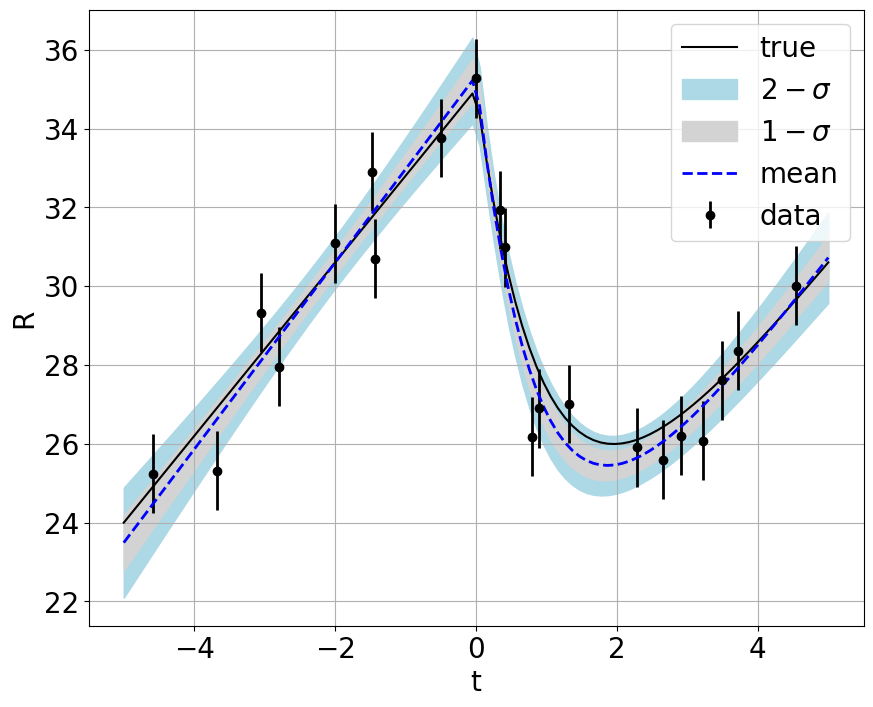

In [28]:
fig=plt.figure(figsize=(10,8))
plt.errorbar(tMes,RMes,yerr=sigma_obs,fmt='o', linewidth=2, capsize=0, c='k', label="data")
plt.plot(t_val,Rtrue_val,c='k',label="true")

plt.fill_between(t_val, Rmean_val-2*std_R_val, Rmean_val+2*std_R_val, 
                    color="lightblue",label=r"$2-\sigma$")
plt.fill_between(t_val, Rmean_val-std_R_val, Rmean_val+std_R_val, 
                    color="lightgray",label=r"$1-\sigma$")
# plot mean prediction
plt.plot(t_val, Rmean_val, "blue", ls="--", lw=2.0, label="mean")


plt.xlabel("t")
plt.ylabel("R")
plt.legend()
plt.grid();

## Etude du tmin (minimum) pour $t>0$: 
$$
\Large
tmin=\tau \times \log\left(\frac{k}{v\tau}\right)
$$

In [29]:
#R0,v,k,tau
par_min = params
par_min

Array([35.35772729,  2.37101488, 16.57771912,  0.93055001], dtype=float64)

In [30]:
inv_hessian_min

Array([[ 0.30761632,  0.09638602,  0.63829193, -0.00407349],
       [ 0.09638602,  0.04649244,  0.26419771,  0.00268041],
       [ 0.63829193,  0.26419771,  1.84092994,  0.04456978],
       [-0.00407349,  0.00268041,  0.04456978,  0.01114726]],      dtype=float64)

In [31]:
#?jax.random.multivariate_normal

In [32]:
rgn_key, new_key = jax.random.split(rng_key)

In [33]:
samples = jax.random.multivariate_normal(new_key, mean=par_min, cov=inv_hessian_min, shape=(5000,)) 

In [34]:
samples = samples.T

In [35]:
def tmin(par):
    #par: R0,v,k,tau
    return par[3]*jnp.log(par[2]/par[3]/par[1])

In [36]:
tmins = tmin(samples)

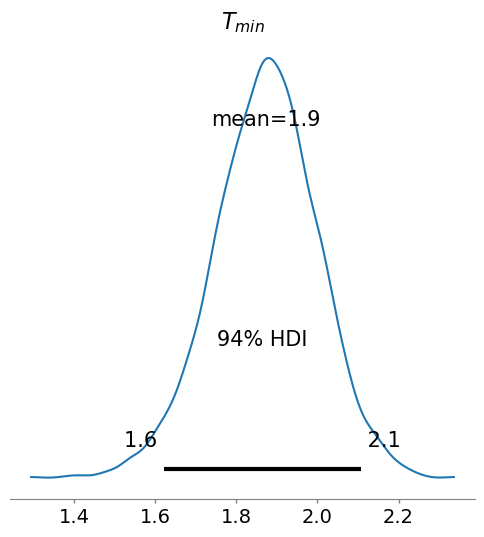

In [37]:
fig,ax=plt.subplots(1,1,figsize=(6,6))
az.plot_posterior({"$T_{min}$":tmins},point_estimate='mean',ax=ax);

# Contours plots: Fisher forecast
$$
\Large
F_{i,j} = \sum_{t:t_{mes}} \frac{1}{\sigma^2} \frac{\partial f(p_{true},t)}{\partial p_i}\frac{\partial f(p_{true},t)}{\partial p_j}
$$
généralisation dans le cas de données avec une matrice de covariance non-diagonale.

In [38]:
def f(p):
    par = {"R0":p[0], "v":p[1], "k":p[2], "tau":p[3]}
    return mean_fn(tMes,par) 

In [39]:
p_true = np.fromiter(par_true.values(), dtype=float)

In [40]:
p_true

array([35. ,  2.2, 15.5,  1. ])

In [41]:
jac = jax.jacfwd(f)(p_true)

In [42]:
jac.shape

(21, 4)

In [43]:
cov_inv = np.zeros((jac.shape[0],jac.shape[0]))
di = np.diag_indices(cov_inv.shape[0])
cov_inv[di]=1./sigma_obs**2

In [44]:
F = jnp.einsum('ia,ij,jb',jac,cov_inv,jac)
F = 0.5*(F+F.T)

In [45]:
from matplotlib.patches import Ellipse

def plot_contours(fisher, pos, inds, nstd=1., ax=None, **kwargs):
  """
  Plot 2D parameter contours given a Hessian matrix of the likelihood
  """
  
  def eigsorted(cov):
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    return vals[order], vecs[:, order]

  mat = fisher
  cov = np.linalg.inv(mat)
  sigma_marg = lambda i: np.sqrt(cov[i, i])

  if ax is None:
      ax = plt.gca()

  # Extracts the block we are interested in
  cov = cov[inds][::,inds]
  vals, vecs = eigsorted(cov)
  theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))

  # Width and height are "full" widths, not radius
  width, height = 2 * nstd * np.sqrt(vals)
  ellip = Ellipse(xy=pos[inds], width=width,
                  height=height, angle=theta, **kwargs)

  ax.add_artist(ellip)
  sz = max(width, height)
  s1 = 1.5*nstd*sigma_marg(0)
  s2 = 1.5*nstd*sigma_marg(1)
  ax.set_xlim(pos[inds[0]] - s1, pos[inds[0]] + s1)
  ax.set_ylim(pos[inds[1]] - s2, pos[inds[1]] + s2)
  plt.draw()
  return ellip

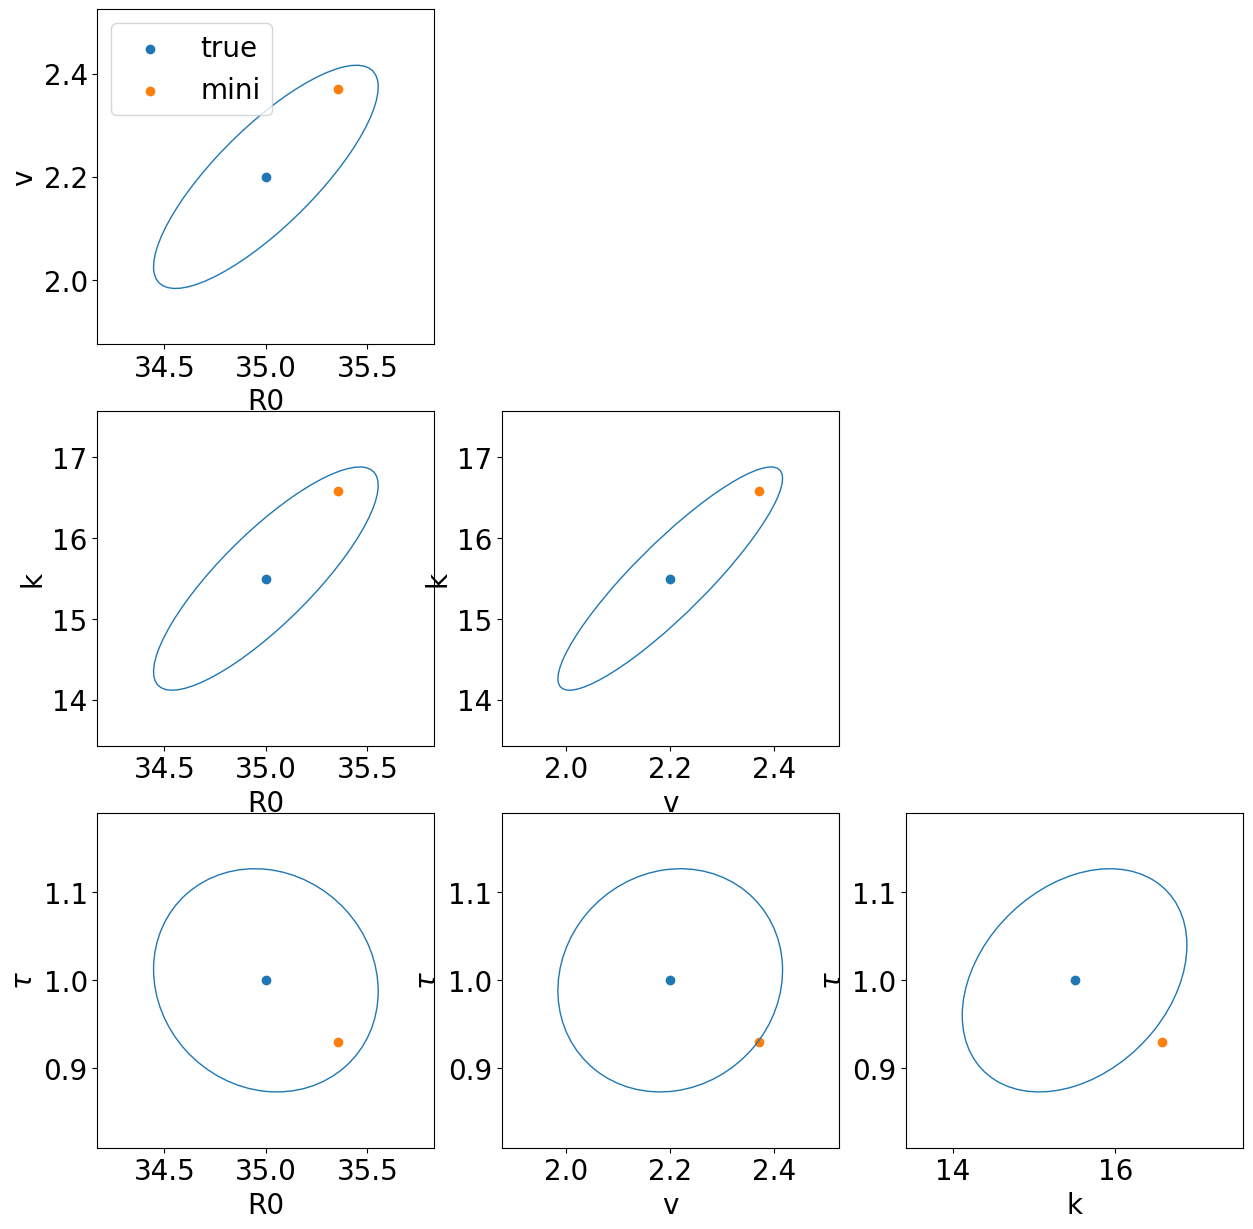

In [46]:
npar = p_true.shape[0]
pname = ["R0","v","k",r"$\tau$"]
plt.figure(figsize=(20, 20))
for i in range(1,npar):
    for j in range(npar):
        if j<i:
            plt.subplot(npar,npar,i*npar+j+1)
            plt.scatter(p_true[j],p_true[i], label="true")
            plt.scatter(par_min[j],par_min[i], label="mini")
            plt.xlabel(pname[j])
            plt.ylabel(pname[i])            
            plot_contours(F, p_true, [j,i],fill=False,color='C0')
            if j==0 and i==1: plt.legend()

In [47]:
import arviz as az
import corner

In [48]:
param_spls.shape

(5000, 4)

In [49]:
data = {"R0":param_spls[:,0], "v":param_spls[:,1],"k":param_spls[:,2],"tau":param_spls[:,3]}

In [50]:
import arviz.labels as azl

labeller = azl.MapLabeller(var_name_map={"R0": r"$R_0$", 
                                         "v":r"$v$",
                                         "k":r"$k$",
                                         "tau":r"$\tau$"})


/Users/dagoret/anaconda3/envs/conda_py310/lib/python3.10/site-packages/arviz/plots/backends/matplotlib/kdeplot.py:166: UserWarning: The following kwargs were not used by contour: 'linewidth', 'linestyle'
  qcs = ax.contour(x_x, y_y, density, **contour_kwargs)


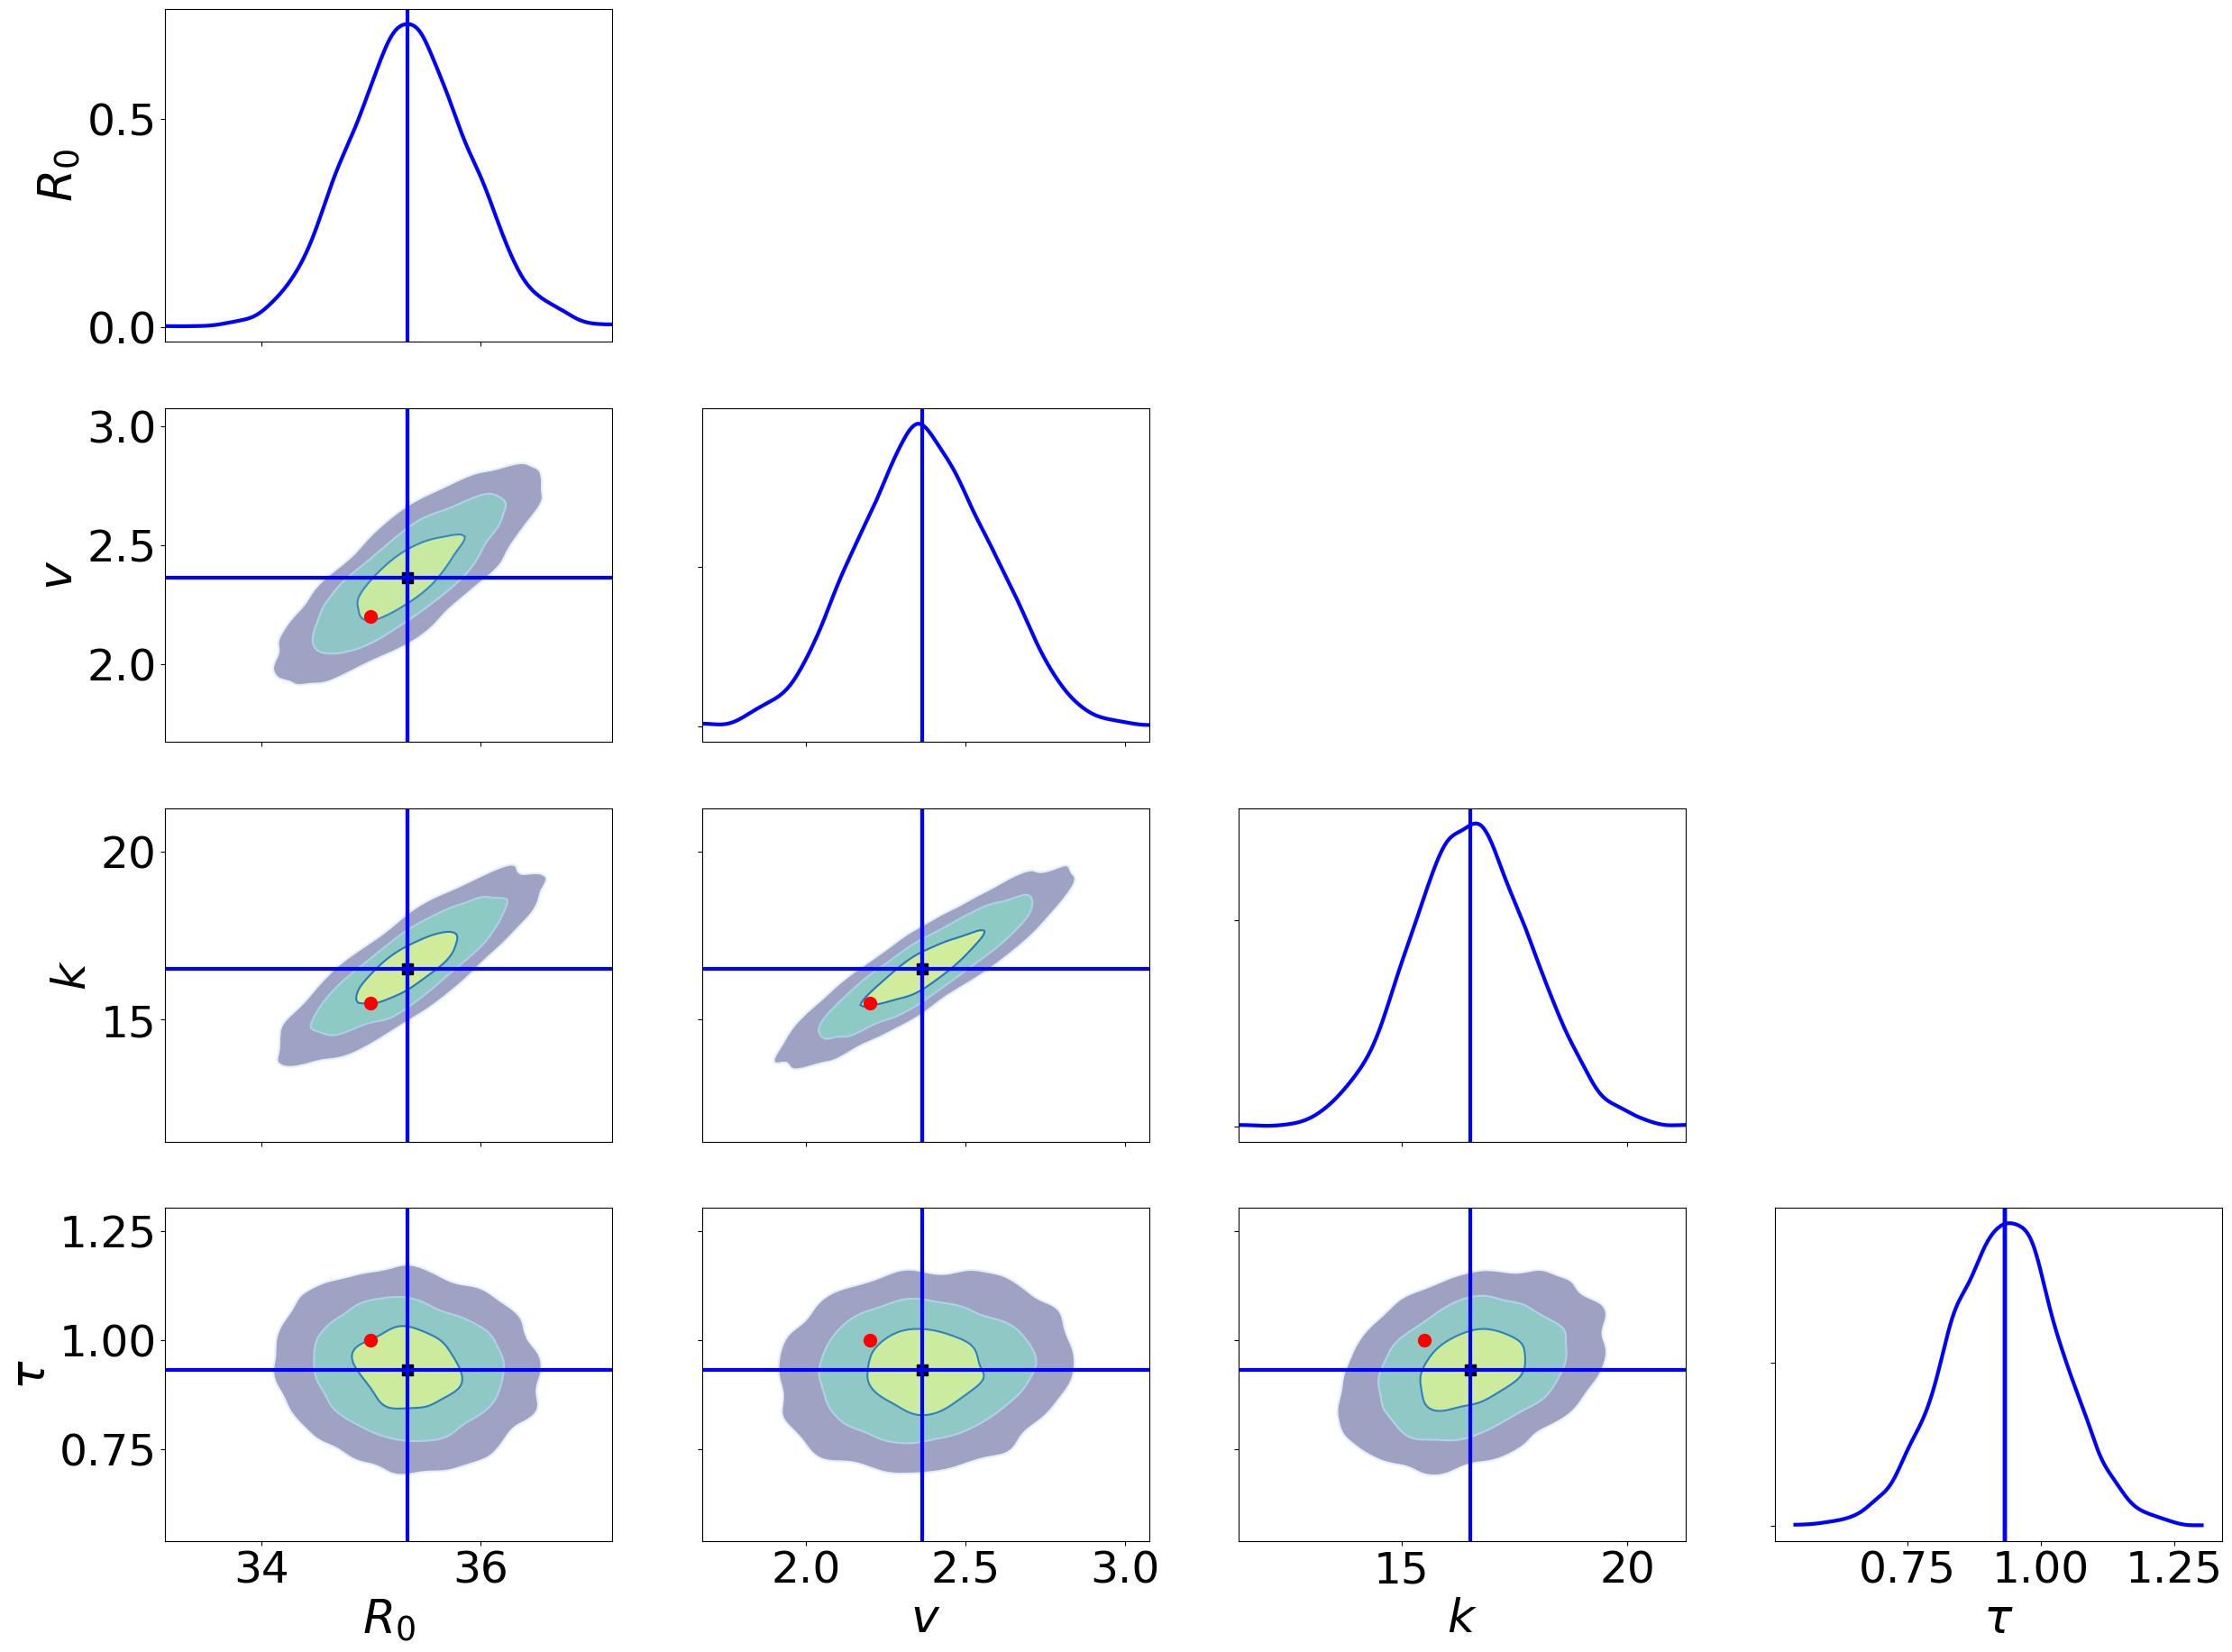

In [51]:
ax=az.plot_pair(
        data,
        kind="kde",
        labeller=labeller,
        marginal_kwargs={"plot_kwargs": {"lw":3, "c":"blue", "ls":"-"}},
        kde_kwargs={
            "hdi_probs": [0.3, 0.68, 0.9],  # Plot 30%, 68% and 90% HDI contours
            "contour_kwargs":{"colors":None, "cmap":"Blues", "linewidths":3,
                              "linestyles":"-"},
            "contourf_kwargs":{"alpha":0.5},
        },
        point_estimate_kwargs={"lw": 3, "c": "b"},
        marginals=True, textsize=35, point_estimate='median',
    );

ax[1,0].scatter(par_true["R0"],par_true["v"],c="r",s=100,zorder=10)
ax[2,0].scatter(par_true["R0"],par_true["k"],c="r",s=100,zorder=10)
ax[2,1].scatter(par_true["v"],par_true["k"],c="r",s=100,zorder=10)
ax[3,0].scatter(par_true["R0"],par_true["tau"],c="r",s=100,zorder=10)
ax[3,1].scatter(par_true["v"],par_true["tau"],c="r",s=100,zorder=10)
ax[3,2].scatter(par_true["k"],par_true["tau"],c="r",s=100,zorder=10)

## Attention: contrairement au Fisher-plot ici les contours sont "centrés" sur les paramètres "médians" des distributions a posteriori

# Minimisation avec contrainte

In [52]:
from jaxopt import ProjectedGradient
from jaxopt.projection import projection_l2_ball, projection_box, projection_l1_ball, projection_polyhedron

In [53]:
#selle de cheval
def f(x):
    return x[0]**2-x[1]**2
# domaine : disque
def constraint(x,r):
    return jnp.atleast_1d(r**2 -((x[0]+1)**2 + (x[1]-1)**2))

In [54]:
# version avec Scipy
r=1.5
sc.optimize.minimize(f, np.array([1, 1]), bounds=((-3, 3), (-3, 3)), method='SLSQP',
         constraints={"fun": constraint, "type": "ineq", 'args': (r,)})

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -5.6235121310184875
       x: [-6.280e-01  2.453e+00]
     nit: 8
     jac: [-1.256e+00 -4.906e+00]
    nfev: 27
    njev: 8

In [55]:
# Avec JaxOpt
def myproj1(x, hyper_params):
    radius = hyper_params   # attetion c'est bien le rayon...
    center = jnp.array([1,-1])
    x = projection_l2_ball(x + center, radius) - center
    return x

Text(0, 0.5, 'Y')

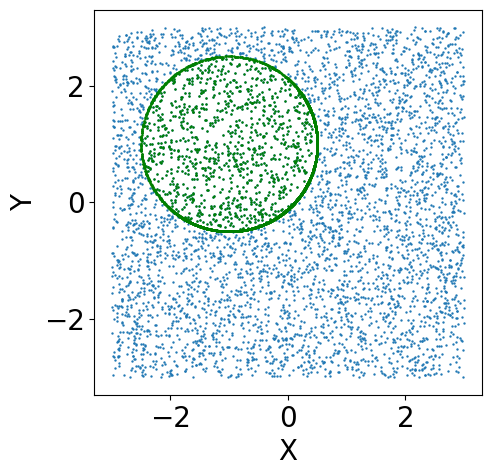

In [56]:
rng_key = jax.random.PRNGKey(42)
r=1.5
x = jax.random.uniform(rng_key, (5000,2), minval=-3,maxval=3)
p1_x=jax.vmap(myproj1, in_axes=(0,None))(x,r)
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(x[:,0],x[:,1],s=0.5)
ax.scatter(p1_x[:,0],p1_x[:,1],s=0.5,c='g')
ax.set_xlabel("X")
ax.set_ylabel("Y")

In [57]:
pg=jaxopt.ProjectedGradient(fun=f,projection=myproj1)#, maxiter=1000, maxls=500)
res = pg.run(init_params=jnp.array([-1.,1.]), hyperparams_proj=r)
print(res.params, "\n", res.state)

[-0.62797252  2.45313301] 
 ProxGradState(iter_num=Array(6, dtype=int64, weak_type=True), stepsize=Array(1., dtype=float64), error=Array(0.00026464, dtype=float64), aux=None, velocity=Array([-0.62780615,  2.45309043], dtype=float64), t=Array(4.36507872, dtype=float64, weak_type=True))


In [58]:
constraint(res.params,r), f(res.params)

(Array([-8.8817842e-16], dtype=float64), Array(-5.62351209, dtype=float64))

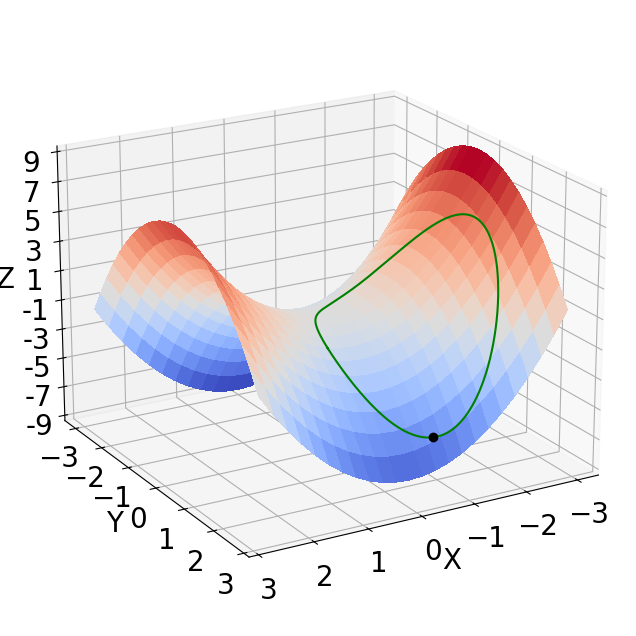

In [59]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(8,8))

# Make data.
X = np.arange(-3, 3, 0.25)
Y = np.arange(-3, 3, 0.25)
X, Y = np.meshgrid(X, Y)
Z = X**2-Y**2

# Make the image of the unit circle
r,xc,yc=1.5,-1.0,1.0
omega = np.linspace(0, 2*np.pi, 2048)
circ_X = r*np.cos(omega)+xc
circ_Y = r*np.sin(omega)+yc
circ_Z = circ_X**2 - circ_Y**2

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
circ = ax.plot(circ_X, circ_Y, circ_Z, color='green',zorder=3)

p_x = res.params[0]
p_y = res.params[1]
p_z = p_x**2 - p_y**2
ax.plot(p_x,p_y,p_z, 'ko', zorder=4)

ax.azim = 60
ax.dist = 10
ax.elev = 20


# Customize the z axis.
#ax.set_zlim(-1.01, 1.01)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.0f}')

# Add a color bar which maps values to colors.
#fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

# Méthode avec Root Finding...

In [60]:
# Volume de la boite 
def vol(x): 
    return x[0]*x[1]*x[2]
# Surface de la boite
def surf(x):
    return 2.*(x[0]*x[1]+x[0]*x[2]+x[1]*x[2])
# Constrainte sur la surface
def g(x): return surf(x) - 24

#Lagrangien : p[0:3] = (x1,x2,x3), p[3] = multiplicateur de lagrange
@jax.jit
def Lag(p): 
    return vol(p[0:3]) - p[3]*g(p[0:3])

gLag = jax.jacfwd(Lag) #gradient

In [61]:
rf = jaxopt.ScipyRootFinding(optimality_fun=gLag, method='hybr', tol=1e-3)
res=rf.run(jnp.array([1.5,0.5,1.0,0.1]))
print("params:",res.params,f"\nvolume: {vol(res.params):.3f}",
      f"surface: {surf(res.params):.3f}")

params: [1.99999457 1.99998668 2.00001261 0.50000053] 
volume: 8.000 surface: 24.000


In [62]:
def plot_lagland(fig,ax,model,bounds):
    xmin,xmax,ymin,ymax = bounds
    grid = x0,y0 = np.mgrid[xmin:xmax:101j,ymin:ymax:101j]

    points = np.swapaxes(grid,0,-1).reshape(-1,2)
    v = jax.vmap(lambda p: model(p), in_axes = (0))(points)
    v = np.swapaxes(v.reshape(101,101),0,-1)
    g=ax.contourf(x0,y0,v, levels = 100,cmap='jet')
    fig.colorbar(g,ax=ax)
    ax.contour(x0,y0,v, levels = 20, colors = 'w')

    grid = np.mgrid[xmin:xmax:30j,ymin:ymax:30j]
    points = np.swapaxes(grid,0,-1).reshape(-1,2)
    gradients = jax.vmap(
        jax.grad(
            lambda p: model(p)
        ), in_axes = (0)
    )(points)

    scale = int(10*np.max(gradients))
    ax.quiver(
        points[:,0],
        points[:,1],
        gradients[:,0],
        gradients[:,1],
        angles = 'xy',
#        scale_units='xy',
        scale = scale
    )
    ax.set_aspect("equal")

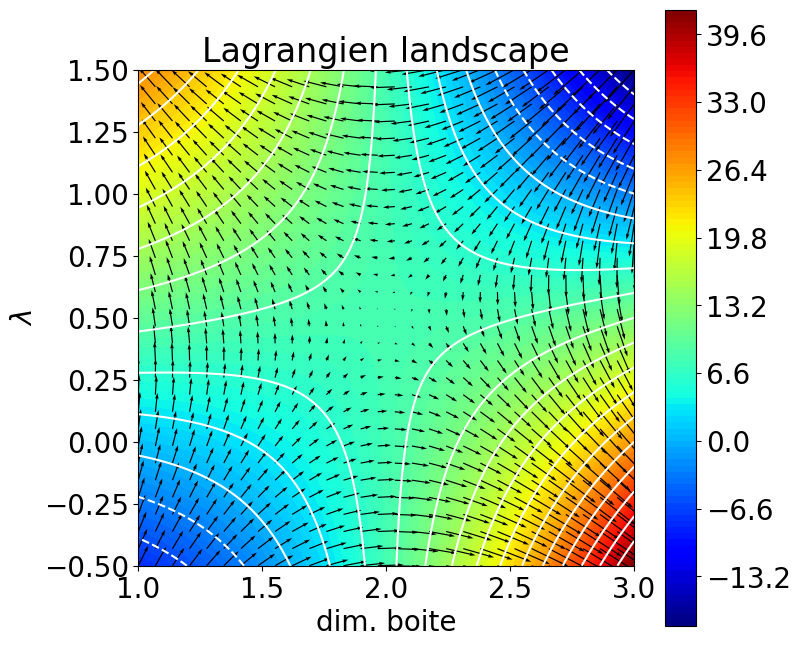

In [63]:
model = lambda p: Lag(jnp.array([p[0],p[0],p[0],p[1]]))
fig,ax = plt.subplots(1,1,figsize=(8,8))
plot_lagland(fig, ax,model,bounds=(1.,3.,-0.5,1.5))
plt.title("Lagrangien landscape")
plt.xlabel("dim. boite")
plt.ylabel(r"$\lambda$")
plt.show()

# Takeaway message:
- usage de `jaxopt` pour faire de l'optimisation: 
    - méthode sans contrainte `GradientDescent`, `optax solver`, `ScipyMinimize`, 
    - méthode avec contarinte `ScipyBoundedMinimize`, `ProjectedGradient`, 
    - méthode `ScipyRootFinding` pour annuler le gradient  
- les gradients et matrice Hessienne sont calculés exactement ce qui consolide la détermination des paramètres et des contours.
- Fisher forecast: facile!
- plusieurs façons de présenter des résultats (`arviz` et home-made), loss landscape, gradient-flow 

# Exercice: résoudre le dernier exemple (méthode lagrangienne)
1) avec une descente de gradient simple: est-ce satisfaisant?
2) avec une descente de grdient avec le hessien: est-ce satisfaisant?
hint: Voir le Tutos `JAX-first-grad-vmap.`
Prendre les paramètres initiaux:
```
p_init = jnp.array([2.,2.,2.,0.2])
p_init = jnp.array([1.5,1.5,1.5,1.0])
p_init = jnp.array([2.,2.,2.,1.])
p_init = jnp.array([1.5,0.5,1.0,0.1])
```

Rappels:
```
#Gradient Lagrangien
gLag = jax.jacfwd(Lag)
hLag = jax.hessian(Lag)

def solveLagrangian_GD(p,lr=1e-3): 
    return p - lr *  gLag(p)
def solveLagrangian_Hess(p,lr=0.1): 
    return p - lr*jnp.linalg.inv(hLag(p)+0.0001*jnp.eye(4)) @ gLag(p)
```

pourquoi ai-je ajouté `0.0001*jnp.eye(4)`?